<a href="https://colab.research.google.com/github/masha-nv/llm/blob/main/llm_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
!wget https://raw.githubusercontent.com/masha-nv/llm/refs/heads/main/names

--2025-03-04 12:43:38--  https://raw.githubusercontent.com/masha-nv/llm/refs/heads/main/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228146 (223K) [text/plain]
Saving to: ‘names.1’

names.1             100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2025-03-04 12:43:38 (4.50 MB/s) - ‘names.1’ saved [228146/228146]



In [53]:
!cd ..
!ls

llm_names.ipynb  names	names.1  README.md


In [55]:
!cd ..
!ls

llm_names.ipynb  names	names.1  README.md


In [50]:
names = open('names.txt', 'r').read().splitlines()

FileNotFoundError: [Errno 2] No such file or directory: 'names.txt'

In [ ]:
# build the vocabulary of characters and mappings to/from integers
characters = sorted(list(set(''.join(names))))
str_to_index = {s:i+1 for i,s in enumerate(characters)}
str_to_index['.'] = 0
index_to_str = {i:s for s,i in str_to_index.items()}
print(str_to_index)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [ ]:
# prepare data set
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    ctx = [0] * block_size
    for ch in w + '.':
      ix = str_to_index[ch]
      X.append(ctx)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      ctx = ctx[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [ ]:
C = torch.randn((27, 10)) # embed each character including '.' into a 10 dim space
W1 = torch.randn((30, 200)) # since context is 3 characters, and each ch is in 10 dim space, each context is 3* 10, 200 is a custom choice for the hidden layer
b1 = torch.randn(200) # biases
W2 = torch.randn((200, 27)) # 2nd hidden layer that feeds into the output layer of possible 27 outcomes
b2 = torch.randn(27) # biases
parameters = [C, W1, b1, W2, b2] # all params in a python list

In [ ]:
sum(p.nelement() for p in parameters) # number of trainable parameters in total

11897

In [ ]:
#adding torch's requires_grad to a tensor - so we can do loss.backward()
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
# tracking statistics
lri = []
lossi = []
stepi = []

In [ ]:
# train for k iterations
k = 10000
for i in range(k):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # shape: (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #shape: (32, 100)
  logits = h @ W2 + b2 #shape: (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

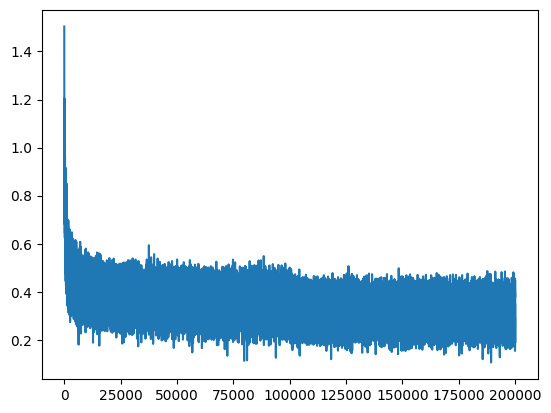

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3193, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3471, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3538, grad_fn=<NllLossBackward0>)

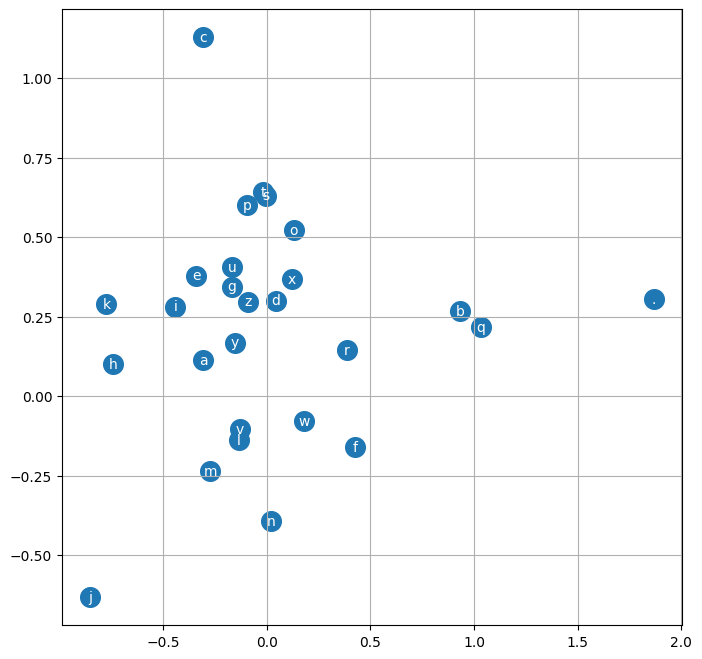

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# generate new names from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    words = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
        break
      words.append(ix)

    print(''.join(index_to_str[i] for i in words))

eriah
myah
keel
neheklarie
mastendrie
cailee
geliiah
pion
jeielleen
narielleigh
kelli
shiterishiriel
kinne
jelionniella
ubettediriyah
fieks
kae
mustonie
hel
calyansun
